# Training and Serving a TensorFlow Model to AI Platform Prediction

This notebooks trains a TensorFlow classification model locally, using the Keras API, and deploys the model to AI Platform for online prediction. The AI Platform model service is also configered to enable request-response logging to BigQuery.

Note that the aim is to build and deploy a **minimal model** to showcase the AI Platform **logging capabilities**, which enable **skew detection** on the serving data and the produced predictions.

The notebook covers the following steps:

1. Prepare the data and generate metadata 
2. Train and evaluate, a TensorFlow classification model using Keras API
3. Export the trained model as a SavedModel for serving
4. Deploy the trained model to AI Platform Prediction 
5. Enabled request-response logging to BigQuery
6. Parse and query logs from BigQuery


This example uses **TensorFlow 2.x**

### Setup

In [1]:
import os
import pandas as pd
import tensorflow as tf

print("TF version: {}".format(tf.__version__))

TF version: 2.1.0-dlenv_tfe


**Set the following variables to match your GCP environment**:

In [2]:
PROJECT = 'mlops-dev-env'
BUCKET =  'mlops-dev-workspace'
GCS_DATA_LOCATION = 'gs://workshop-datasets/covertype/data_validation'
REGION = 'us-central1'
LOCAL_WORKSPACE = '/home/jupyter/workspace'
LOCAL_DATA_DIR = os.path.join(LOCAL_WORKSPACE, 'data')
BQ_DATASET_NAME = 'data_validation'
BQ_TABLE_NAME = 'covertype_classifier_logs'
MODEL_NAME = 'covertype_classifier'
VERSION_NAME = 'v2'
TRAINING_DIR = os.path.join(LOCAL_WORKSPACE, 'training')
MODEL_DIR = os.path.join(TRAINING_DIR, 'exported_model')

In [3]:
!gcloud config set project {PROJECT}

Updated property [core/project].


Create a local workspace

In [4]:
if tf.io.gfile.exists(LOCAL_WORKSPACE):
  print("Removing previous workspace artifacts...")
  tf.io.gfile.rmtree(LOCAL_WORKSPACE)

print("Creating a new workspace...")
tf.io.gfile.makedirs(LOCAL_WORKSPACE)
tf.io.gfile.makedirs(LOCAL_DATA_DIR)

Creating a new workspace...


## 1. Dataset preparation and schema generation

We use the [covertype](https://archive.ics.uci.edu/ml/datasets/covertype) from UCI Machine Learning Repository. The task is to Predict forest cover type from cartographic variables only. 

The dataset is preprocessed, split, and uploaded to uploaded to the `gs://workshop-datasets/covertype` public GCS location. 

We use this version of the preprocessed dataset in this notebook. For more information, see [Cover Type Dataset](https://github.com/GoogleCloudPlatform/mlops-on-gcp/tree/master/datasets/covertype)

### 1.1. Download the data

In [5]:
LOCAL_TRAIN_DATA = os.path.join(LOCAL_DATA_DIR, 'train.csv') 
LOCAL_EVAL_DATA = os.path.join(LOCAL_DATA_DIR, 'eval.csv') 

In [6]:
!gsutil cp gs://workshop-datasets/covertype/data_validation/training/dataset.csv {LOCAL_TRAIN_DATA}
!gsutil cp gs://workshop-datasets/covertype/data_validation/evaluation/dataset.csv {LOCAL_EVAL_DATA}
!wc -l {LOCAL_TRAIN_DATA}

Copying gs://workshop-datasets/covertype/data_validation/training/dataset.csv...
- [1 files][ 22.2 MiB/ 22.2 MiB]                                                
Operation completed over 1 objects/22.2 MiB.                                     
Copying gs://workshop-datasets/covertype/data_validation/evaluation/dataset.csv...
/ [1 files][  3.9 MiB/  3.9 MiB]                                                
Operation completed over 1 objects/3.9 MiB.                                      
431010 /home/jupyter/workspace/data/train.csv


In [7]:
sample = pd.read_csv(LOCAL_TRAIN_DATA).head()
sample.T

,0,1,2,3,4
Elevation,3034,2827,2854,3188,3091
Aspect,235,26,27,156,61
Slope,13,16,12,13,8
Horizontal_Distance_To_Hydrology,655,85,484,175,134
Vertical_Distance_To_Hydrology,134,13,22,28,10
Horizontal_Distance_To_Roadways,5799,3511,618,3666,1390
Hillshade_9am,197,211,215,235,227
Hillshade_Noon,251,204,214,241,223
Hillshade_3pm,190,125,134,134,129
Horizontal_Distance_To_Fire_Points,4094,6008,1295,1719,2868


### 1.2 Define metadata

In [33]:
HEADER = ['Elevation', 'Aspect', 'Slope','Horizontal_Distance_To_Hydrology',
          'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
          'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
          'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area', 'Soil_Type',
          'Cover_Type']

TARGET_FEATURE_NAME = 'Cover_Type'

FEATURE_LABELS = ['0', '1', '2', '3', '4', '5', '6']

NUMERIC_FEATURE_NAMES = ['Aspect', 'Elevation', 'Hillshade_3pm', 
                         'Hillshade_9am', 'Hillshade_Noon', 
                         'Horizontal_Distance_To_Fire_Points',
                         'Horizontal_Distance_To_Hydrology',
                         'Horizontal_Distance_To_Roadways','Slope',
                         'Vertical_Distance_To_Hydrology']

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    'Soil_Type': ['2702', '2703', '2704', '2705', '2706', '2717', '3501', '3502', 
                  '4201', '4703', '4704', '4744', '4758', '5101', '6101', '6102', 
                  '6731', '7101', '7102', '7103', '7201', '7202', '7700', '7701', 
                  '7702', '7709', '7710', '7745', '7746', '7755', '7756', '7757', 
                  '7790', '8703', '8707', '8708', '8771', '8772', '8776'], 
    'Wilderness_Area': ['Cache', 'Commanche', 'Neota', 'Rawah']
}

FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys()) + NUMERIC_FEATURE_NAMES

HEADER_DEFAULTS = [[0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ['NA'] 
                   for feature_name in HEADER]

NUM_CLASSES = len(FEATURE_LABELS)

## 2. Model training and evaluation

### 2.1. Implement data input pipeline

In [34]:
RANDOM_SEED = 19830610
import multiprocessing

def create_dataset(file_pattern, 
                  batch_size=128, num_epochs=1, shuffle=False):
  
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=file_pattern,
        batch_size=batch_size,
        column_names=HEADER,
        column_defaults=HEADER_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        field_delim=',',
        header=True,
        num_epochs=num_epochs,
        shuffle=shuffle,
        shuffle_buffer_size=(5 * batch_size),
        shuffle_seed=RANDOM_SEED,
        num_parallel_reads=multiprocessing.cpu_count(),
        sloppy=True,
    )
    return dataset.cache()

In [35]:
index = 1
for batch in create_dataset(LOCAL_TRAIN_DATA, batch_size=5, shuffle=False).take(2):
  print("Batch: {}".format(index))
  print("========================")
  record, target = batch
  print("Input features:")
  for key in record:
    print(" - {}:{}".format(key, record[key].numpy()))
  print("Target: {}".format(target))
  index += 1
  print()

Batch: 1
Input features:
 - Elevation:[3034 2827 2854 3188 3091]
 - Aspect:[235  26  27 156  61]
 - Slope:[13 16 12 13  8]
 - Horizontal_Distance_To_Hydrology:[655  85 484 175 134]
 - Vertical_Distance_To_Hydrology:[134  13  22  28  10]
 - Horizontal_Distance_To_Roadways:[5799 3511  618 3666 1390]
 - Hillshade_9am:[197 211 215 235 227]
 - Hillshade_Noon:[251 204 214 241 223]
 - Hillshade_3pm:[190 125 134 134 129]
 - Horizontal_Distance_To_Fire_Points:[4094 6008 1295 1719 2868]
 - Wilderness_Area:[b'Rawah' b'Rawah' b'Commanche' b'Commanche' b'Commanche']
 - Soil_Type:[b'7745' b'7745' b'4704' b'7756' b'7202']
Target: [1 1 1 1 0]

Batch: 2
Input features:
 - Elevation:[2993 3276 2864 3183 2587]
 - Aspect:[ 35 343 319 138  80]
 - Slope:[ 8 11 29 23  5]
 - Horizontal_Distance_To_Hydrology:[636 849 228 268 234]
 - Vertical_Distance_To_Hydrology:[ 90 -14  98  85  28]
 - Horizontal_Distance_To_Roadways:[3355 1776  577 3872 1350]
 - Hillshade_9am:[219 199 134 248 227]
 - Hillshade_Noon:[224 224

### 2.2. Create feature columns

In [36]:
import math

def create_feature_columns():
  feature_columns = []
  
  for feature_name in FEATURE_NAMES:
    # Categorical features
    if feature_name in CATEGORICAL_FEATURES_WITH_VOCABULARY:
      
      vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
      vocab_size = len(vocabulary)
      
      # Create embedding column for categotical feature column with vocabulary
      embedding_feature_column = tf.feature_column.embedding_column(
          categorical_column = tf.feature_column.categorical_column_with_vocabulary_list(
              key=feature_name,
              vocabulary_list=vocabulary), dimension=int(math.sqrt(vocab_size) + 1))
            
      feature_columns.append(embedding_feature_column)

    # Numeric features
    else:
      numeric_column = tf.feature_column.numeric_column(feature_name)
      feature_columns.append(numeric_column)

  return feature_columns


In [37]:
feature_columns = create_feature_columns()

for column in feature_columns:
  print(column)

EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='Soil_Type', vocabulary_list=('2702', '2703', '2704', '2705', '2706', '2717', '3501', '3502', '4201', '4703', '4704', '4744', '4758', '5101', '6101', '6102', '6731', '7101', '7102', '7103', '7201', '7202', '7700', '7701', '7702', '7709', '7710', '7745', '7746', '7755', '7756', '7757', '7790', '8703', '8707', '8708', '8771', '8772', '8776'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=7, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f0599c52d90>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)
EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='Wilderness_Area', vocabulary_list=('Cache', 'Commanche', 'Neota', 'Rawah'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=3, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f0598473ed0>, ckpt_to_load_

### 2.3. Create and compile the model



In [38]:
def create_model(params):

  feature_columns = create_feature_columns()
  
  layers = []
  layers.append(tf.keras.layers.DenseFeatures(feature_columns))
  for units in params.hidden_units:
    layers.append(tf.keras.layers.Dense(units=units, activation='relu'))
    layers.append(tf.keras.layers.BatchNormalization())
    layers.append(tf.keras.layers.Dropout(rate=params.dropout))
  
  layers.append(tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax', name='output'))
  
  model = tf.keras.Sequential(layers=layers, name='classifier')
    
  adam_optimzer = tf.keras.optimizers.Adam(learning_rate=params.learning_rate)

  model.compile(
        optimizer=adam_optimzer, 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()], 
        loss_weights=None,
        sample_weight_mode=None, 
        weighted_metrics=None, 
    )

  return model  

### 2.4. Train and evaluate experiment

#### Experiment

In [39]:
def run_experiment(model, params):

  # TensorBoard callback
  LOG_DIR = os.path.join(TRAINING_DIR, 'logs')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

  # Early stopping callback
  earlystopping_callback = tf.keras.callbacks.EarlyStopping(
      monitor='val_sparse_categorical_accuracy', 
      patience=3, 
      restore_best_weights=True
  )

  callbacks = [
        tensorboard_callback,
        earlystopping_callback]

  # train dataset
  train_dataset = create_dataset(
      LOCAL_TRAIN_DATA,
      batch_size=params.batch_size,
      shuffle=True)
    
  # eval dataset
  eval_dataset = create_dataset(
      LOCAL_EVAL_DATA,
      batch_size=params.batch_size)
    
  # Prep training directory
  if tf.io.gfile.exists(TRAINING_DIR):
    print("Removing previous training artefacts...")
    tf.io.gfile.rmtree(TRAINING_DIR)

  print("Creating training directory...")
  tf.io.gfile.mkdir(TRAINING_DIR)

  print("Experiment started...")
  print(".......................................")
  
  # Run train and evaluate.
  history = model.fit(
    x=train_dataset, 
    epochs=params.epochs, 
    callbacks=callbacks,
    validation_data=eval_dataset,
  )

  print(".......................................")
  print("Experiment finished.")
  print("")

  return history


#### Hyper parameters

In [40]:
class Parameters():
    pass

TRAIN_DATA_SIZE = 431010

params = Parameters()
params.learning_rate = 0.01
params.hidden_units = [128, 128]
params.dropout = 0.15
params.batch_size =  265
params.steps_per_epoch = int(math.ceil(TRAIN_DATA_SIZE / params.batch_size))
params.epochs = 3

#### Run experiment

In [41]:
model = create_model(params)
example_batch, _ = list(
    create_dataset(LOCAL_TRAIN_DATA, batch_size=2, shuffle=True).take(1))[0]
model(example_batch)
model.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_1 (DenseFeatu multiple                  285       
_________________________________________________________________
dense_2 (Dense)              multiple                  2688      
_________________________________________________________________
batch_normalization_2 (Batch multiple                  512       
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  16512     
_________________________________________________________________
batch_normalization_3 (Batch multiple                  512       
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0

In [42]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

history = run_experiment(model, params)

Removing previous training artefacts...
Creating training directory...
Experiment started...
.......................................
Epoch 1/3
1627/1627 [==============================] - 47s 29ms/step - loss: 0.6651 - sparse_categorical_accuracy: 0.7170 - val_loss: 0.6170 - val_sparse_categorical_accuracy: 0.7330
Epoch 2/3
1627/1627 [==============================] - 28s 17ms/step - loss: 0.5944 - sparse_categorical_accuracy: 0.7437 - val_loss: 0.5866 - val_sparse_categorical_accuracy: 0.7343
Epoch 3/3
1627/1627 [==============================] - 28s 17ms/step - loss: 0.5720 - sparse_categorical_accuracy: 0.7531 - val_loss: 0.5588 - val_sparse_categorical_accuracy: 0.7498
.......................................
Experiment finished.



#### Visualize training history

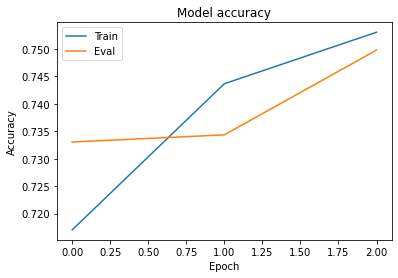

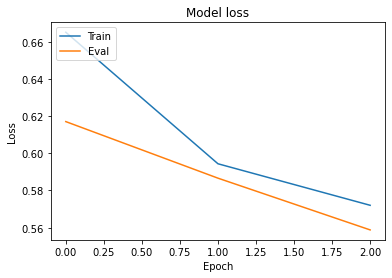

In [43]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc='upper left')
plt.show()

## 3. Model export for serving

### 3.1. Implement serving input receiver functions

#### Feature spec

In [44]:
feature_spec = {}
for feature_name in FEATURE_NAMES:
    if feature_name in CATEGORICAL_FEATURES_WITH_VOCABULARY:
        feature_spec[feature_name] = tf.io.FixedLenFeature(
            shape=(1,), dtype=tf.string)
    else:
        feature_spec[feature_name] = tf.io.FixedLenFeature(
            shape=(1,), dtype=tf.float32)

for key, value in feature_spec.items():
  print("{}: {}".format(key, value))

Soil_Type: FixedLenFeature(shape=(1,), dtype=tf.string, default_value=None)
Wilderness_Area: FixedLenFeature(shape=(1,), dtype=tf.string, default_value=None)
Aspect: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Elevation: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Hillshade_3pm: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Hillshade_9am: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Hillshade_Noon: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Horizontal_Distance_To_Fire_Points: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Horizontal_Distance_To_Hydrology: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Horizontal_Distance_To_Roadways: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Slope: FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)
Vertical_Distance_To_Hydrology: FixedLenFeature(shape=(1,), dtype=tf.floa

#### Features serving function

In [45]:
MODEL_OUTPUT_KEY = 'probabilities'

def make_features_serving_fn_default(model):

  @tf.function
  def serve_features_fn(features):

    # implement any required preprocessing here

    return {MODEL_OUTPUT_KEY: model(features)}

  return serve_features_fn

In [45]:
MODEL_OUTPUT_KEY = 'probabilities'

def make_features_serving_fn_alt(model):

  @tf.function
  def serve_features_fn(features):

    # implement any required preprocessing here

    return {MODEL_OUTPUT_KEY: model(features)}

  return serve_features_fn

### 3.2. Export the model

In [46]:
SIGNATURE_NAME = 'serving_default'

features_input_signature = {
    feature: tf.TensorSpec(shape=spec.shape, dtype=spec.dtype, name=feature)
    for feature, spec in feature_spec.items()
    }

signatures = {        
    SIGNATURE_NAME: make_features_serving_fn(model).get_concrete_function(
        features_input_signature),
    }

model.save(MODEL_DIR, save_format='tf', signatures=signatures)
print("Model is exported to: {}.".format(MODEL_DIR))

Model is exported to: /home/jupyter/workspace/training/exported_model.


In [47]:
!saved_model_cli show --dir {MODEL_DIR} --tag_set serve --signature_def {SIGNATURE_NAME}

The given SavedModel SignatureDef contains the following input(s):
  inputs['Aspect'] tensor_info:
      dtype: DT_FLOAT
      shape: (1)
      name: serving_default_Aspect:0
  inputs['Elevation'] tensor_info:
      dtype: DT_FLOAT
      shape: (1)
      name: serving_default_Elevation:0
  inputs['Hillshade_3pm'] tensor_info:
      dtype: DT_FLOAT
      shape: (1)
      name: serving_default_Hillshade_3pm:0
  inputs['Hillshade_9am'] tensor_info:
      dtype: DT_FLOAT
      shape: (1)
      name: serving_default_Hillshade_9am:0
  inputs['Hillshade_Noon'] tensor_info:
      dtype: DT_FLOAT
      shape: (1)
      name: serving_default_Hillshade_Noon:0
  inputs['Horizontal_Distance_To_Fire_Points'] tensor_info:
      dtype: DT_FLOAT
      shape: (1)
      name: serving_default_Horizontal_Distance_To_Fire_Points:0
  inputs['Horizontal_Distance_To_Hydrology'] tensor_info:
      dtype: DT_FLOAT
      shape: (1)
      name: serving_default_Horizontal_Distance_To_Hydrology:0
  inputs['Horizonta

### 3.3. Test exported model

In [48]:
instances = [
      { 'Soil_Type': '7202',
        'Wilderness_Area': 'Commanche',
        'Aspect': 61,
        'Elevation': 3091,
        'Hillshade_3pm': 129,
        'Hillshade_9am': 227,
        'Hillshade_Noon': 223,
        'Horizontal_Distance_To_Fire_Points': 2868,
        'Horizontal_Distance_To_Hydrology': 134,
        'Horizontal_Distance_To_Roadways': 0, 
        'Slope': 8, 
        'Vertical_Distance_To_Hydrology': 10,
    }
]

#### Preidct using features_serving signature

In [49]:
import numpy as np

def create_tf_features(instance):
 
  new_instance = {}
  for key, value in instance.items():
    if key in CATEGORICAL_FEATURES_WITH_VOCABULARY or key in SKIP_INPUTS:
      new_instance[key] = tf.constant(value, dtype=tf.string)
    else:
      new_instance[key] = tf.constant(value, dtype=tf.float32)
  
  return new_instance

In [50]:
features_predictor = tf.saved_model.load(MODEL_DIR).signatures[SIGNATURE_NAME]

def predict_features_serving(instance):

  features = create_tf_features(instance)
  probabilities = features_predictor(**features)[MODEL_OUTPUT_KEY].numpy()
  predictions = FEATURE_LABELS[int(np.argmax(probabilities))]

  return predictions

In [51]:
predict_features_serving(instances[0])

'1'

### 3.4  Upload exported model to GCS

In [52]:
!gsutil rm -r gs://{BUCKET}/models/{MODEL_NAME}
!gsutil cp -r {MODEL_DIR} gs://{BUCKET}/models/{MODEL_NAME}

Removing gs://mlops-dev-workspace/models/covertype_classifier/saved_model.pb#1588284890224018...
Removing gs://mlops-dev-workspace/models/covertype_classifier/variables/variables.data-00000-of-00001#1588284890656293...
Removing gs://mlops-dev-workspace/models/covertype_classifier/variables/variables.index#1588284890438224...
/ [3 objects]                                                                   
Operation completed over 3 objects.                                              
Copying file:///home/jupyter/workspace/training/exported_model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/workspace/training/exported_model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/workspace/training/exported_model/variables/variables.index [Content-Type=application/octet-stream]...
- [3 files][  1.1 MiB/  1.1 MiB]                                                
Operation completed over 3 obj

## 4. Model deployment to AI Platform 


### 4.1. Create model in AI Platform

In [55]:
!gcloud ai-platform models create {MODEL_NAME} \
  --project {PROJECT} \
  --regions {REGION}

Created ml engine model [projects/mlops-dev-env/models/covertype_classifier].


In [56]:
!gcloud ai-platform models list --project {PROJECT}

NAME                  DEFAULT_VERSION_NAME
covertype_classifier


### 4.2. Create a model version

In [57]:
!gcloud ai-platform versions create {VERSION_NAME} \
  --model={MODEL_NAME} \
  --origin=gs://{BUCKET}/models/{MODEL_NAME} \
  --runtime-version=2.1 \
  --framework=TENSORFLOW \
  --python-version=3.7 \
  --project={PROJECT}

!gcloud ai-platform versions list --model={MODEL_NAME} --project={PROJECT}

Creating version (this might take a few minutes)......done.                    
NAME  DEPLOYMENT_URI                                        STATE
v2    gs://mlops-dev-workspace/models/covertype_classifier  READY


### 4.3. Test deployed model

In [58]:
import googleapiclient.discovery

service = googleapiclient.discovery.build('ml', 'v1')
name = 'projects/{}/models/{}/versions/{}'.format(PROJECT, MODEL_NAME, VERSION_NAME)
print("Service name: {}".format(name))

def caip_predict(instances):
  
  serving_instances = []
  for instance in instances:
    serving_instances.append(
        {key: [value] for key, value in instance.items()})
    
  request_body={
      'signature_name': SIGNATURE_NAME,
      'instances': serving_instances}

  response = service.projects().predict(
      name=name,
      body=request_body

  ).execute()

  if 'error' in response:
    raise RuntimeError(response['error'])

  probability_list = [output[MODEL_OUTPUT_KEY] for output in response['predictions']]
  classes = [FEATURE_LABELS[int(np.argmax(probabilities))] for probabilities in probability_list]
  return classes

Service name: projects/mlops-dev-env/models/covertype_classifier/versions/v2


In [59]:
caip_predict(instances)

['1']